# American Monte Carlo Demo

Pupose: American Monte Carlo (a.k.a. Least Squares Monte Carlo or Longstaff-Schwartz Monte Carlo) demonstration on equity options. The following option types are supported:

| Exercise Style | Option Type | Barrier Type |
|----------------|-------------|--------------|
| European       | Call / Put  | None         |
| American       | Call / Put  | None         |
| European       | Put         | Down-and-In  |
| American       | Put         | Down-and-In  |

Note that Down-and-In barriers are only supported for `barrier_level` $< S_0$.

Option prices calculated with American Monte Carlo algorithm can be compared to QuantLib pricing engine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
from american_monte_carlo import *

In [3]:
# Underlying asset path settings
np.random.seed(42)
S0 = 95  # Initial stock price
K = 100  # Strike price
T = 1.0  # Maturity in years
r = 0.01  # Risk-free rate
sigma = 0.2  # Volatility of the underlying stock
n_time_steps = 100  # Number of time steps (excluding S0)
n_paths = 1000  # Number of Monte Carlo paths
dt = T / n_time_steps  # Time step size

# Payoff settings
option_type = "Put"
exercise_type = "European"
barrier_level = None

# Regression settings
basis_type = "Chebyshev"
degree = 4

# Plot settings
n_plotted_paths = 1000
difference_type = "difference"
vmin_diff, vmax_diff = None, None

In [4]:
paths = generate_asset_paths(S0, r, sigma, T, n_time_steps, n_paths)

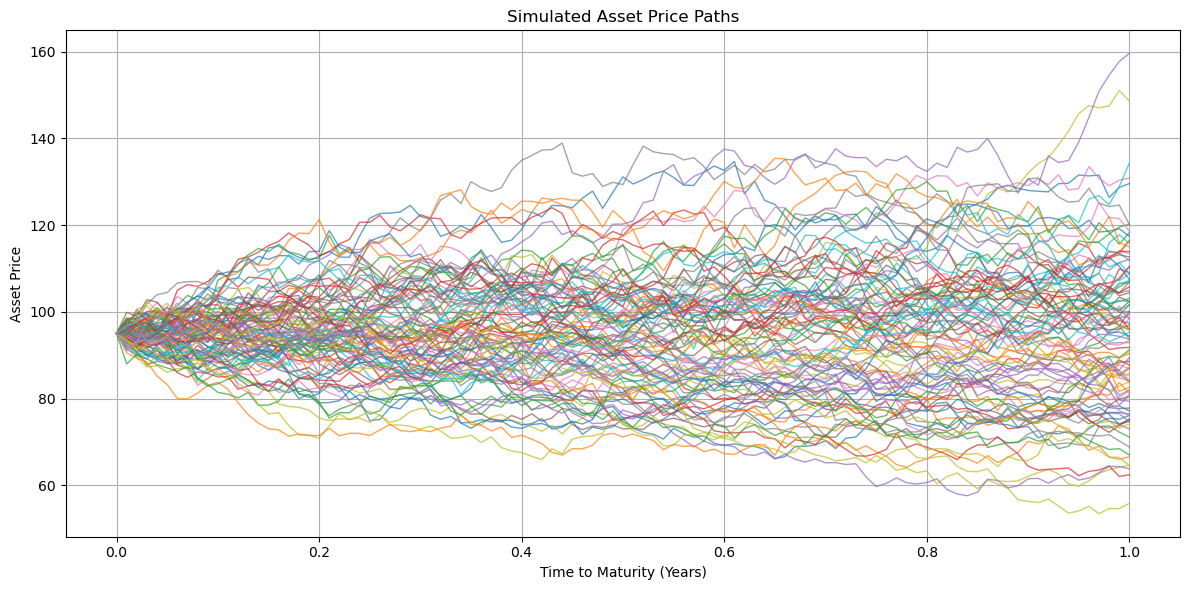

In [5]:
def plot_asset_paths(paths, T, n_time_steps, n_paths_to_plot=100):
    plt.figure(figsize=(12, 6))
    time_steps = np.linspace(0, T, n_time_steps + 1)  
    for i in range(n_paths_to_plot):
        plt.plot(time_steps, paths[i], lw=1, alpha=0.7)

    plt.title("Simulated Asset Price Paths")
    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel("Asset Price")
    plt.grid()
    plt.tight_layout()
    plt.show()


plot_asset_paths(paths, T, n_time_steps)

In [6]:
lsmc_price, continuation_values = lsmc_option_pricing(paths, K, r, dt, option_type, barrier_level,
                                                      exercise_type, basis_type, degree)

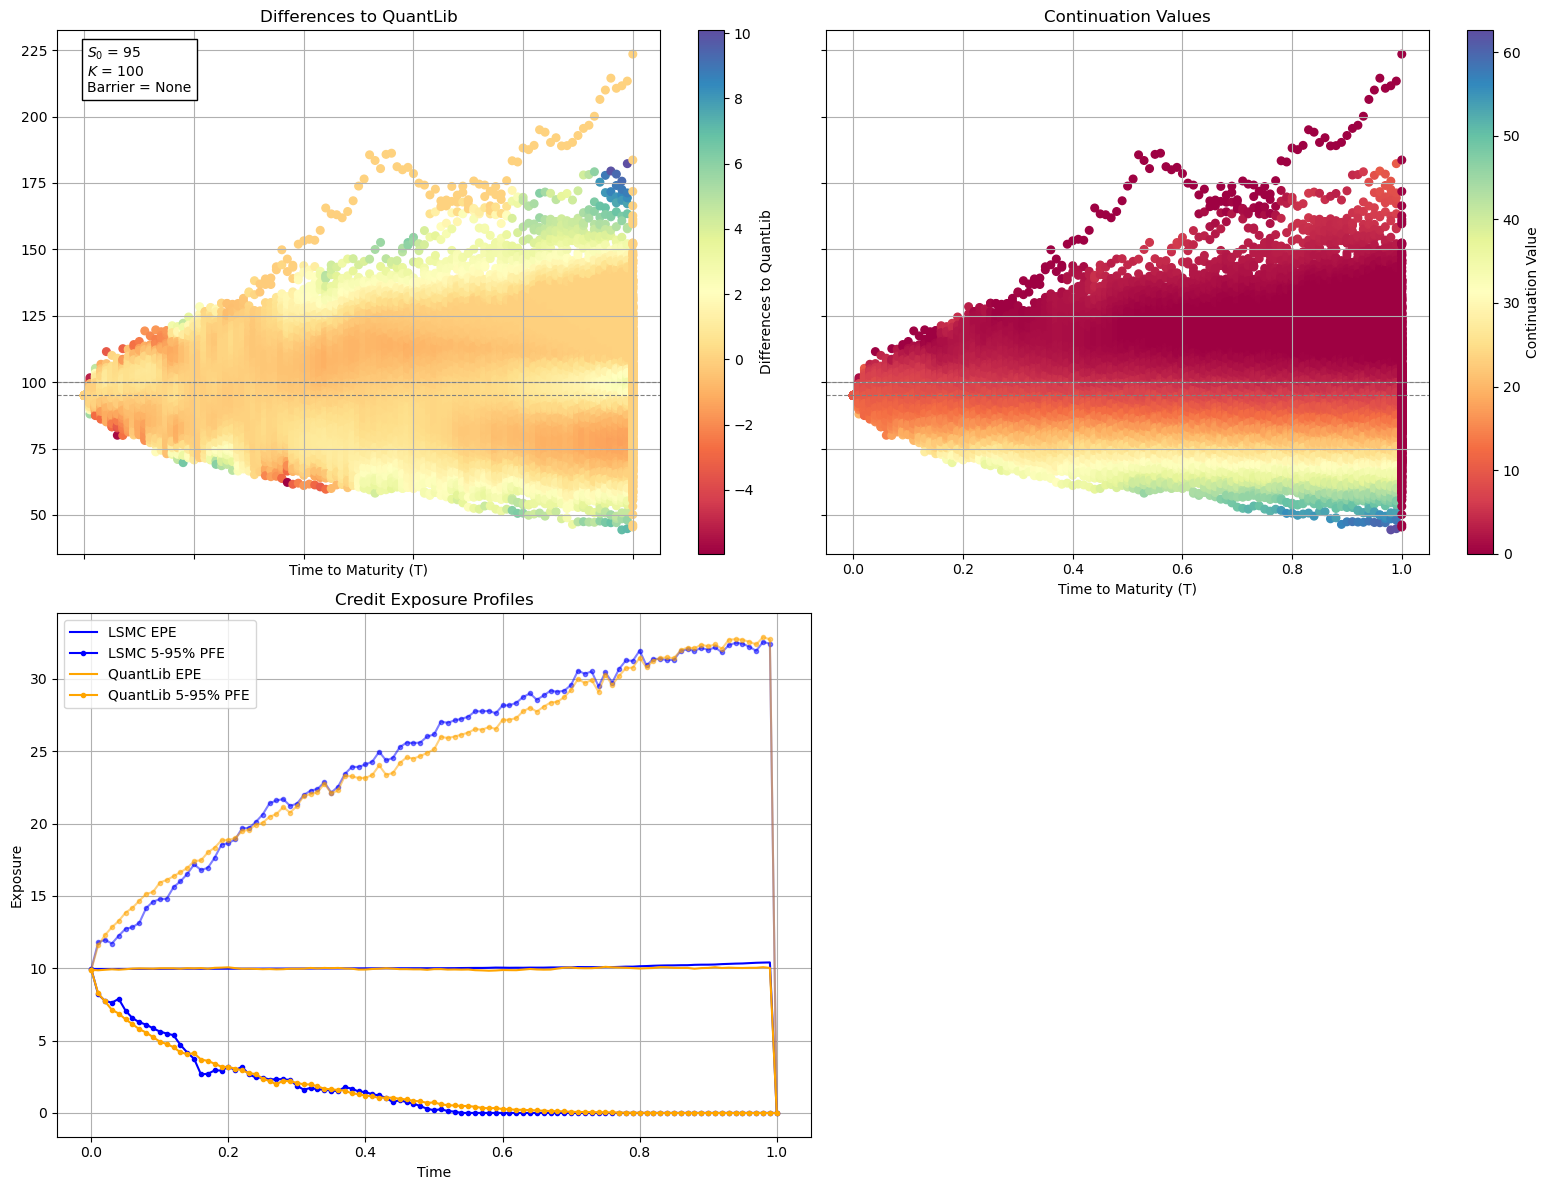

In [7]:
# Compute QuantLib values at every grid point using all paths
quantlib_option_values = compute_quantlib_values(paths, dt, K, r, T, sigma, n_time_steps, option_type,
                                                 exercise_type, barrier_level)

# Compute CCR measures
quantlib_ccr_exposures = compute_ccr_exposures(quantlib_option_values)
lsmc_ccr_exposures = compute_ccr_exposures(continuation_values)

# Crop data for plotting
cont_values_cropped, quantlib_values_cropped, paths_cropped = crop_data(continuation_values, quantlib_option_values,
                                                                        paths, min(n_plotted_paths, n_paths))
key_S_lines = [S0, K, barrier_level] if barrier_level else [S0, K]

# Plot results
plot_lsmc_results(
    cont_values_cropped, paths_cropped, dt, quantlib_values_cropped,
    lsmc_ccr_exposures, quantlib_ccr_exposures,
    difference_type=difference_type, key_S_lines=key_S_lines, plot_asset_paths=False,
    vmin_diff=vmin_diff, vmax_diff=vmax_diff, S0=S0, K=K, barrier_level=barrier_level
)

In [8]:
# Compare LSMC with QuantLib
quantlib_barrier_option = get_quantlib_option(S0, K, r, T, sigma, n_time_steps, option_type, exercise_type,
                                              barrier_level)
option_description = f"{exercise_type} {option_type}"
barrier_text = f"with Barrier at {barrier_level}" if barrier_level else "without Barrier"
print(f"{option_description} Option Price {barrier_text} (LSMC): {lsmc_price:.4f}")
print(f"{option_description} Option Price {barrier_text} (QuantLib): {quantlib_barrier_option.NPV():.4f}")
if barrier_level:
    quantlib_option = get_quantlib_option(S0, K, r, T, sigma, n_time_steps, option_type, exercise_type)
    print(f"{option_description} Option Price without Barrier (QuantLib): {quantlib_option.NPV():.4f}")


European Put Option Price without Barrier (LSMC): 9.9485
European Put Option Price without Barrier (QuantLib): 9.8928


## Another example without barrier, now with early exercise: **American Put option**

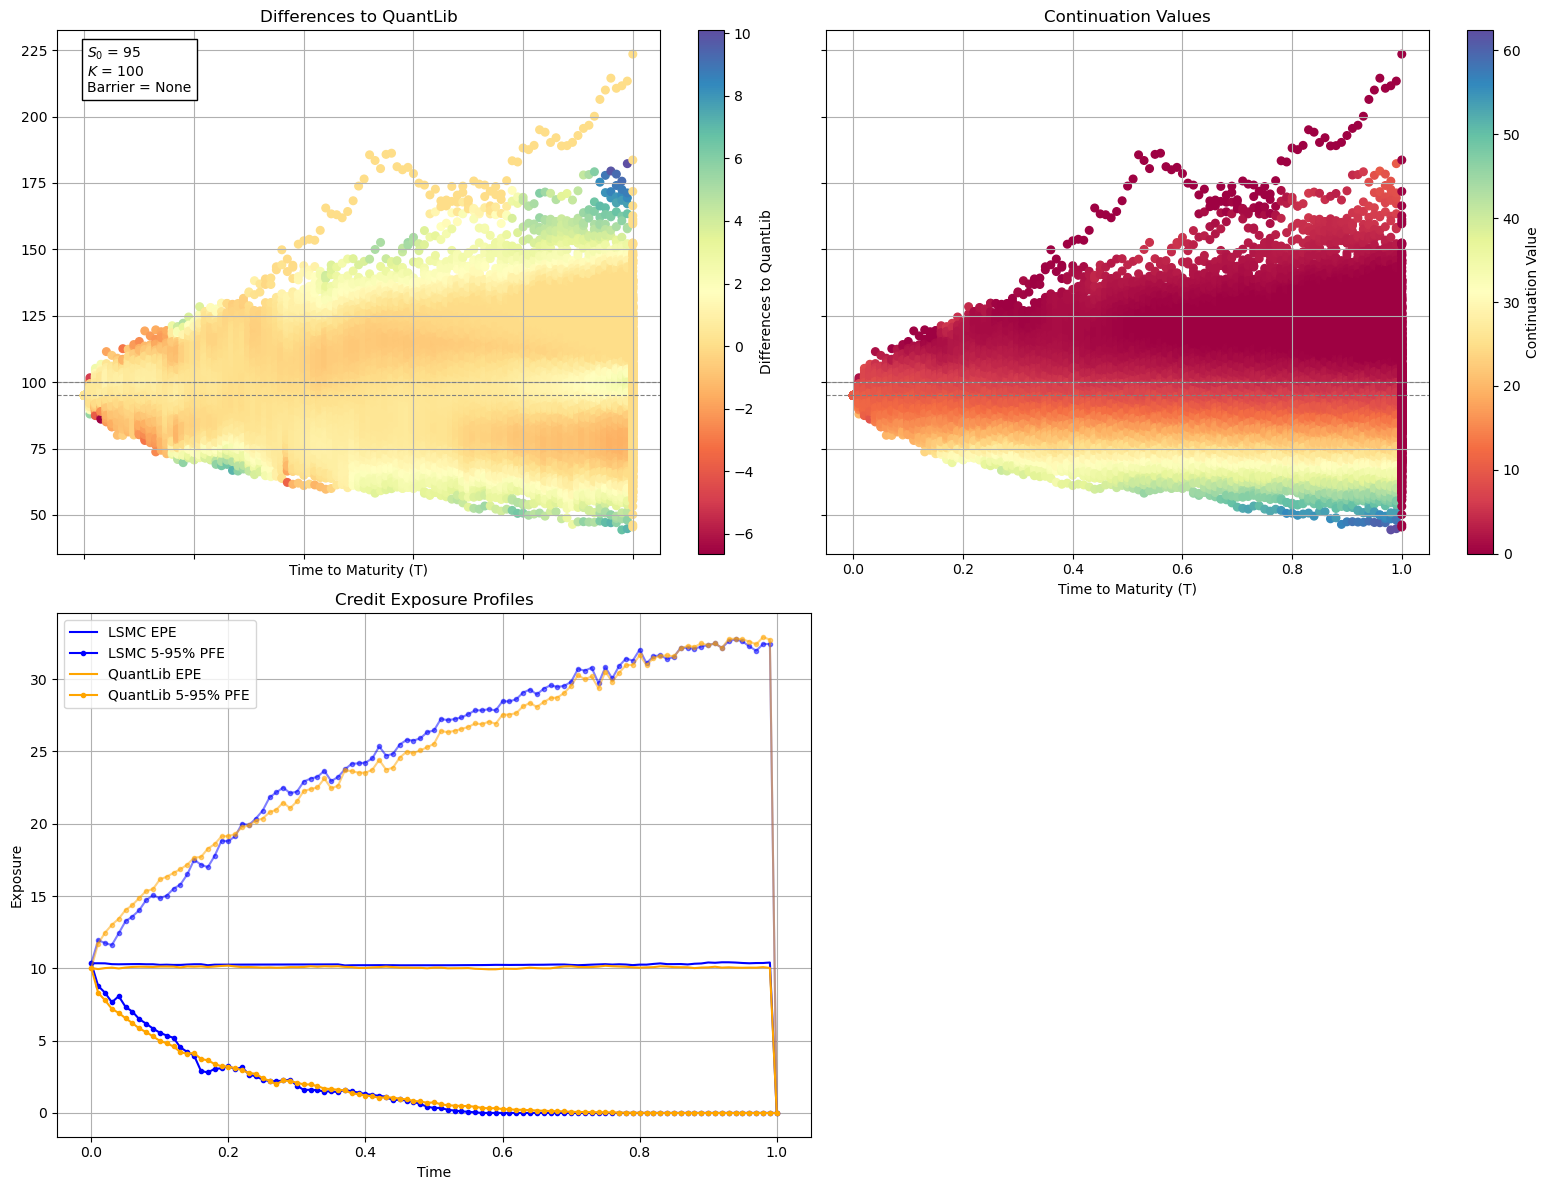

American Put Option Price without Barrier (LSMC): 10.3494
American Put Option Price without Barrier (QuantLib): 10.0198


In [9]:
params = {
    # Underlying asset path settings
    "S0": 95,  # Initial stock price
    "K": 100,  # Strike price
    "T": 1.0,  # Maturity in years
    "r": 0.01,  # Risk-free rate
    "sigma": 0.2,  # Volatility of the underlying stock
    "n_time_steps": 100,  # Number of time steps (excluding S0)
    "n_paths": 1000,  # Number of Monte Carlo paths
    # Payoff settings
    "option_type": "Put",  # Option type
    "exercise_type": "American",  # Exercise type
    "barrier_level": None,    # Barrier level
    # Regression settings
    "basis_type": "Chebyshev",
    "degree": 4,
    # Plot settings
    "n_plotted_paths": 1000,
    "difference_type": "difference",
    "vmin_diff": None,
    "vmax_diff": None
}


np.random.seed(42)
main(params)

## Another example *WITH* barrier: *Down-In-Put option, 70% barrier*

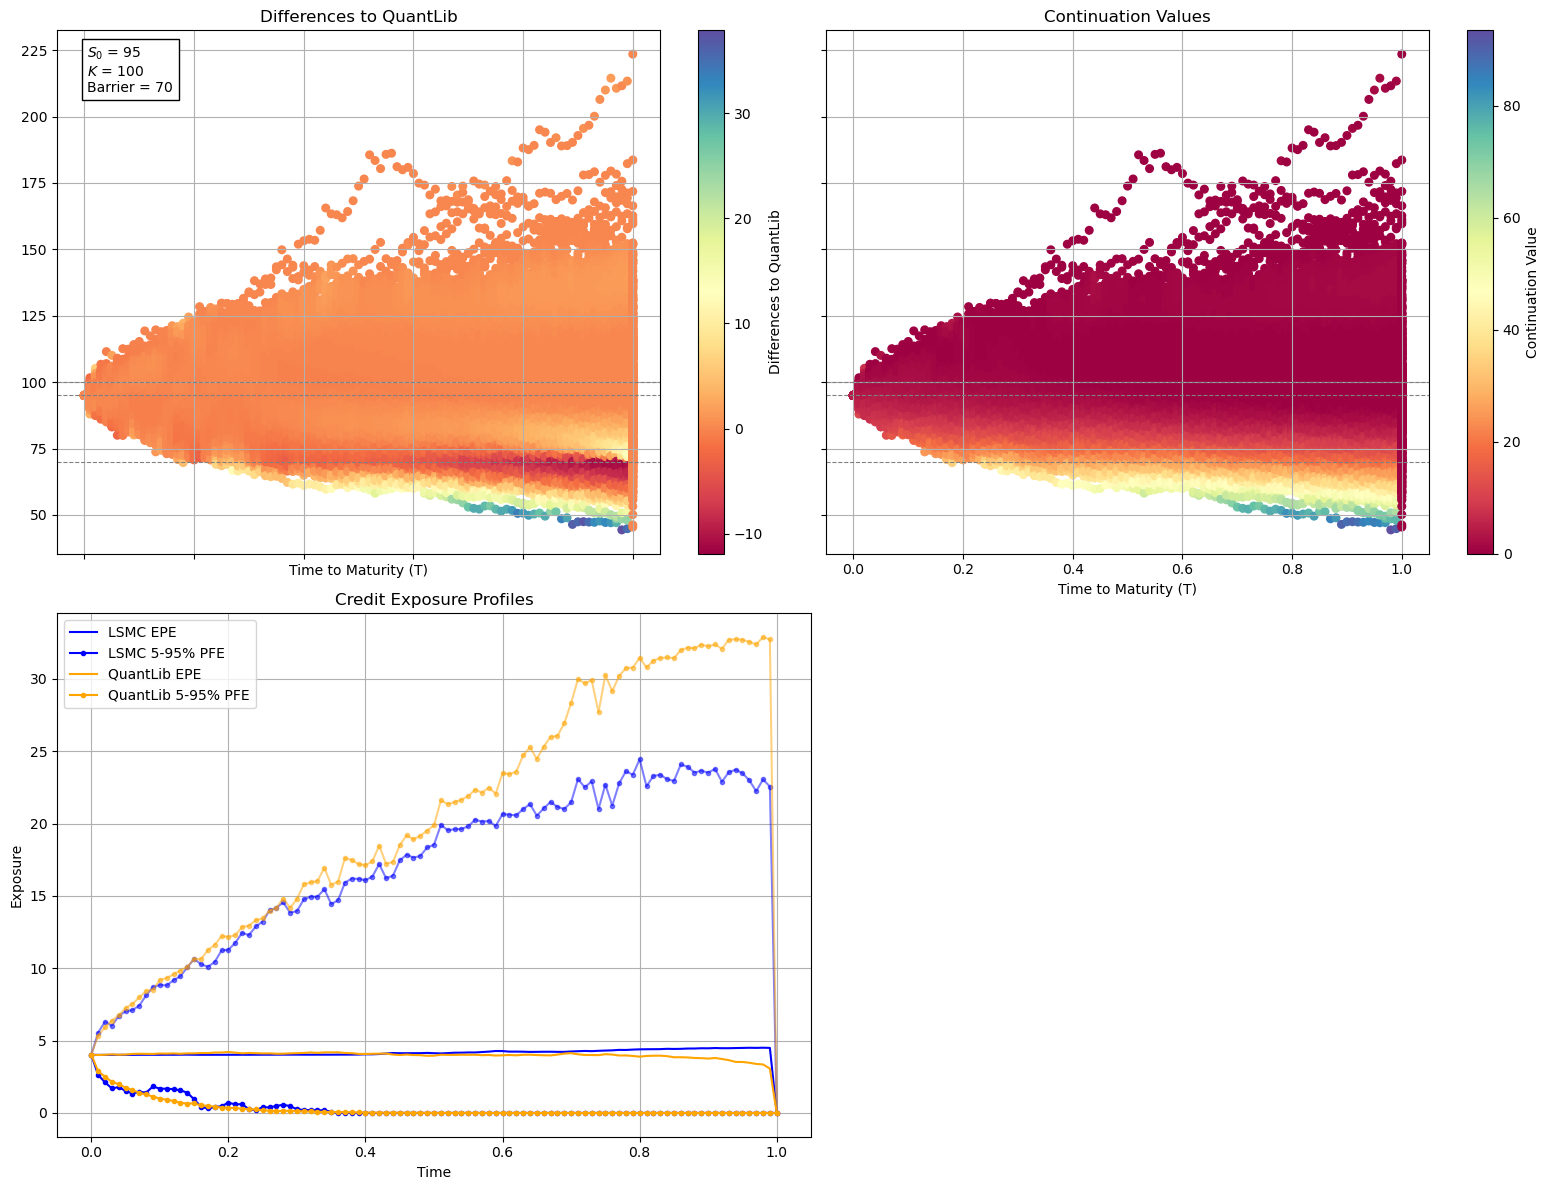

European Put Option Price with Barrier at 70 (LSMC): 4.0108
European Put Option Price with Barrier at 70 (QuantLib): 4.0316
European Put Option Price without Barrier (QuantLib): 9.8928


In [10]:
params = {
    # Underlying asset path settings
    "S0": 95,  # Initial stock price
    "K": 100,  # Strike price
    "T": 1.0,  # Maturity in years
    "r": 0.01,  # Risk-free rate
    "sigma": 0.2,  # Volatility of the underlying stock
    "n_time_steps": 100,  # Number of time steps (excluding S0)
    "n_paths": 1000,  # Number of Monte Carlo paths
    # Payoff settings
    "option_type": "Put",  # Option type
    "exercise_type": "European",  # Exercise type
    "barrier_level": 70,    # Barrier level
    # Regression settings
    "basis_type": "Chebyshev",
    "degree": 4,
    # Plot settings
    "n_plotted_paths": 1000,
    "difference_type": "difference",
    "vmin_diff": None,
    "vmax_diff": None
}


np.random.seed(42)
main(params)

#### Let us increase the MC parameters ...

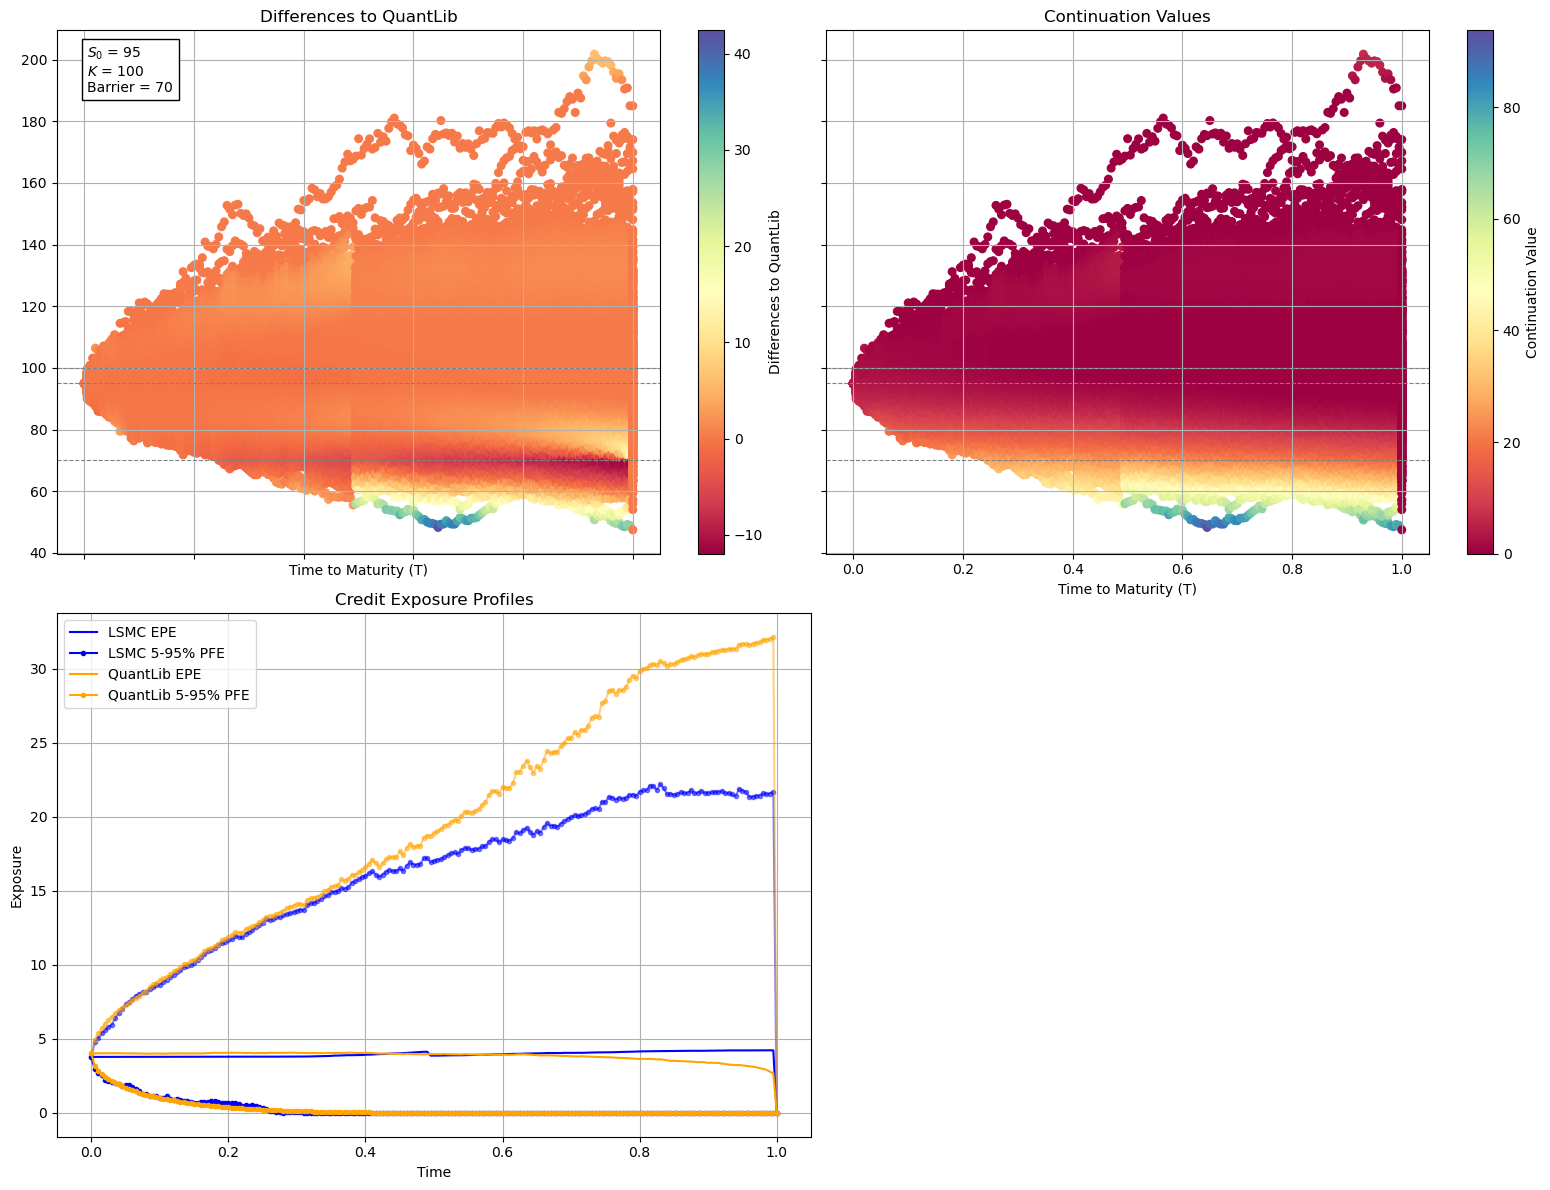

European Put Option Price with Barrier at 70 (LSMC): 3.7835
European Put Option Price with Barrier at 70 (QuantLib): 4.0316
European Put Option Price without Barrier (QuantLib): 9.8928


In [11]:
params = {
    # Underlying asset path settings
    "S0": 95,  # Initial stock price
    "K": 100,  # Strike price
    "T": 1.0,  # Maturity in years
    "r": 0.01,  # Risk-free rate
    "sigma": 0.2,  # Volatility of the underlying stock
    "n_time_steps": 200,  # Number of time steps (excluding S0)
    "n_paths": 10000,  # Number of Monte Carlo paths
    # Payoff settings
    "option_type": "Put",  # Option type
    "exercise_type": "European",  # Exercise type
    "barrier_level": 70,    # Barrier level
    # Regression settings
    "basis_type": "Chebyshev",
    "degree": 4,
    # Plot settings
    "n_plotted_paths": 1000,
    "difference_type": "difference",
    "vmin_diff": None,
    "vmax_diff": None
}


np.random.seed(42)
main(params)

#### Or the degree of polynomial regression ...

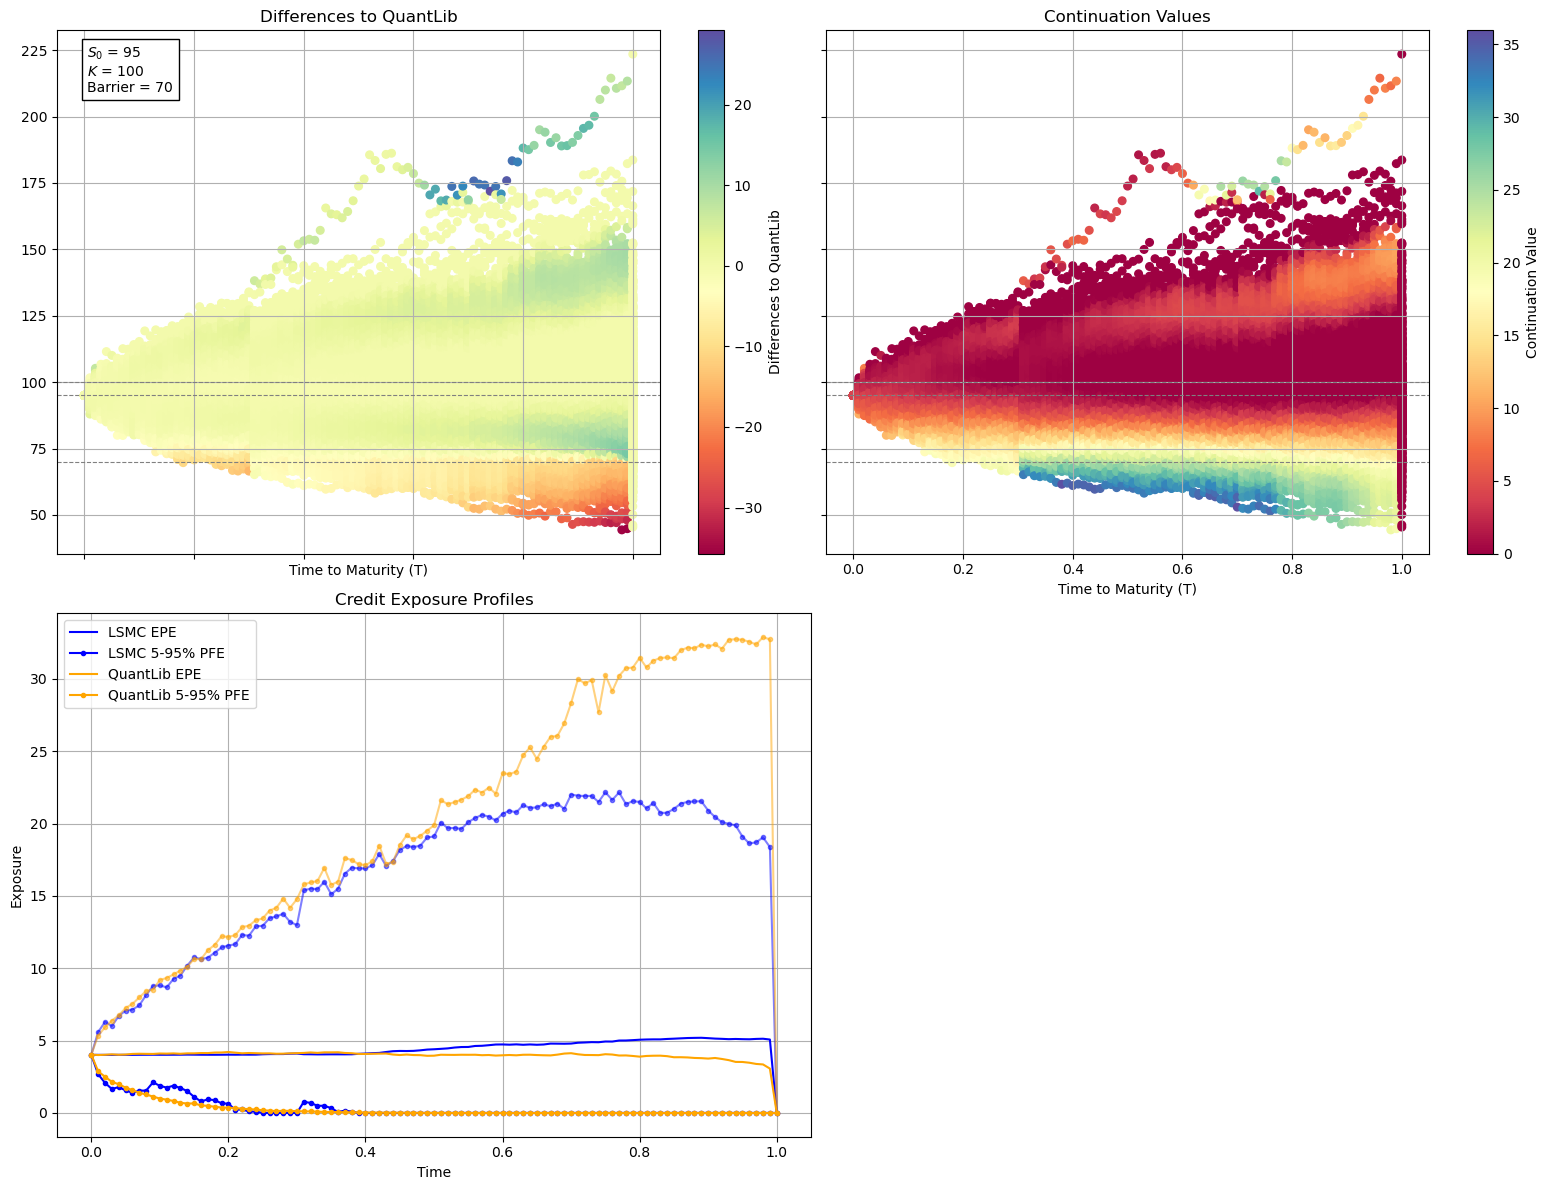

European Put Option Price with Barrier at 70 (LSMC): 4.0108
European Put Option Price with Barrier at 70 (QuantLib): 4.0316
European Put Option Price without Barrier (QuantLib): 9.8928


In [12]:
params = {
    # Underlying asset path settings
    "S0": 95,  # Initial stock price
    "K": 100,  # Strike price
    "T": 1.0,  # Maturity in years
    "r": 0.01,  # Risk-free rate
    "sigma": 0.2,  # Volatility of the underlying stock
    "n_time_steps": 100,  # Number of time steps (excluding S0)
    "n_paths": 1000,  # Number of Monte Carlo paths
    # Payoff settings
    "option_type": "Put",  # Option type
    "exercise_type": "European",  # Exercise type
    "barrier_level": 70,    # Barrier level
    # Regression settings
    "basis_type": "Chebyshev",
    "degree": 7,
    # Plot settings
    "n_plotted_paths": 1000,
    "difference_type": "difference",
    "vmin_diff": None,
    "vmax_diff": None
}


np.random.seed(42)
main(params)

## AMC Convergence Analysis

#### 1 - AMC convergence w.r.t. polynomial basis chosen

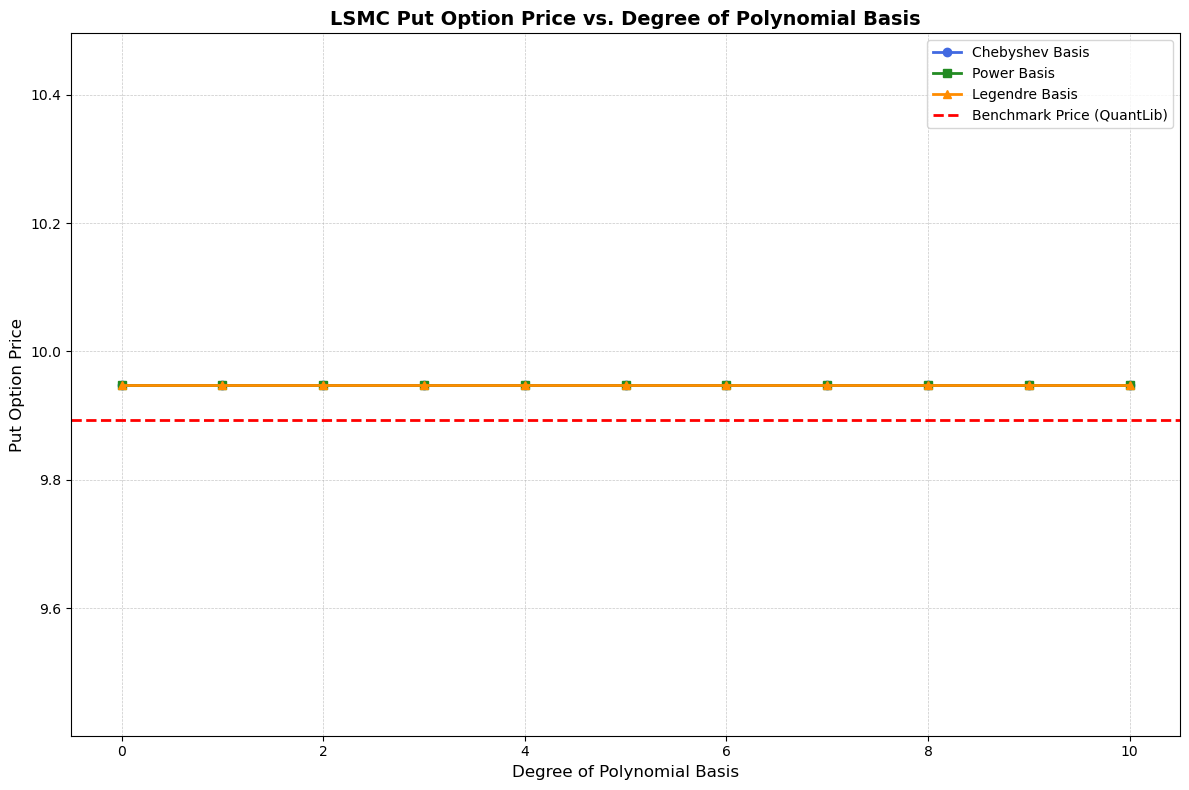

In [13]:
def plot_error_vs_basis_degree(S0, K, r, T, sigma, n_time_steps, n_paths, option_type, exercise_type, barrier_level,
                               max_degree):
    degrees = range(0, max_degree + 1)
    benchmark_option = get_quantlib_option(S0, K, r, T, sigma, n_time_steps, option_type, exercise_type, barrier_level)
    benchmark_price = benchmark_option.NPV()

    paths = generate_asset_paths(S0, r, sigma, T, n_time_steps, n_paths)

    plt.figure(figsize=(12, 8))
    color_map = {'Chebyshev': "royalblue", 'Power': "forestgreen", 'Legendre': "darkorange"}
    marker_map = {'Chebyshev': "o", 'Power': "s", 'Legendre': "^"}

    for basis_type in ["Chebyshev", "Power", "Legendre"]:
        lsmc_prices = []
        for degree in degrees:
            lsmc_price, _ = lsmc_option_pricing(paths, K, r, T / n_time_steps, option_type, barrier_level,
                                                exercise_type, basis_type=basis_type, degree=degree)
            lsmc_prices.append(lsmc_price)

        plt.plot(degrees, lsmc_prices, label=f"{basis_type} Basis",
                 color=color_map[basis_type], marker=marker_map[basis_type],
                 linewidth=2, markersize=6)

    # Benchmark line
    plt.axhline(benchmark_price, color='red', linestyle='--', linewidth=2, label='Benchmark Price (QuantLib)')

    # Plot styling
    plt.xlabel("Degree of Polynomial Basis", fontsize=12)
    plt.ylabel(f"{option_type} Option Price", fontsize=12)
    plt.title(f"LSMC {option_type} Option Price vs. Degree of Polynomial Basis", fontsize=14, fontweight='bold')
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


exercise_type = "European"
np.random.seed(42)
plot_error_vs_basis_degree(S0=S0, K=K, r=r, T=T, sigma=sigma, n_time_steps=n_time_steps, n_paths=n_paths,
                           option_type=option_type, exercise_type=exercise_type, barrier_level=barrier_level,
                           max_degree=10)

### 2 - AMC convergence w.r.t. number of MC paths in asset path generation

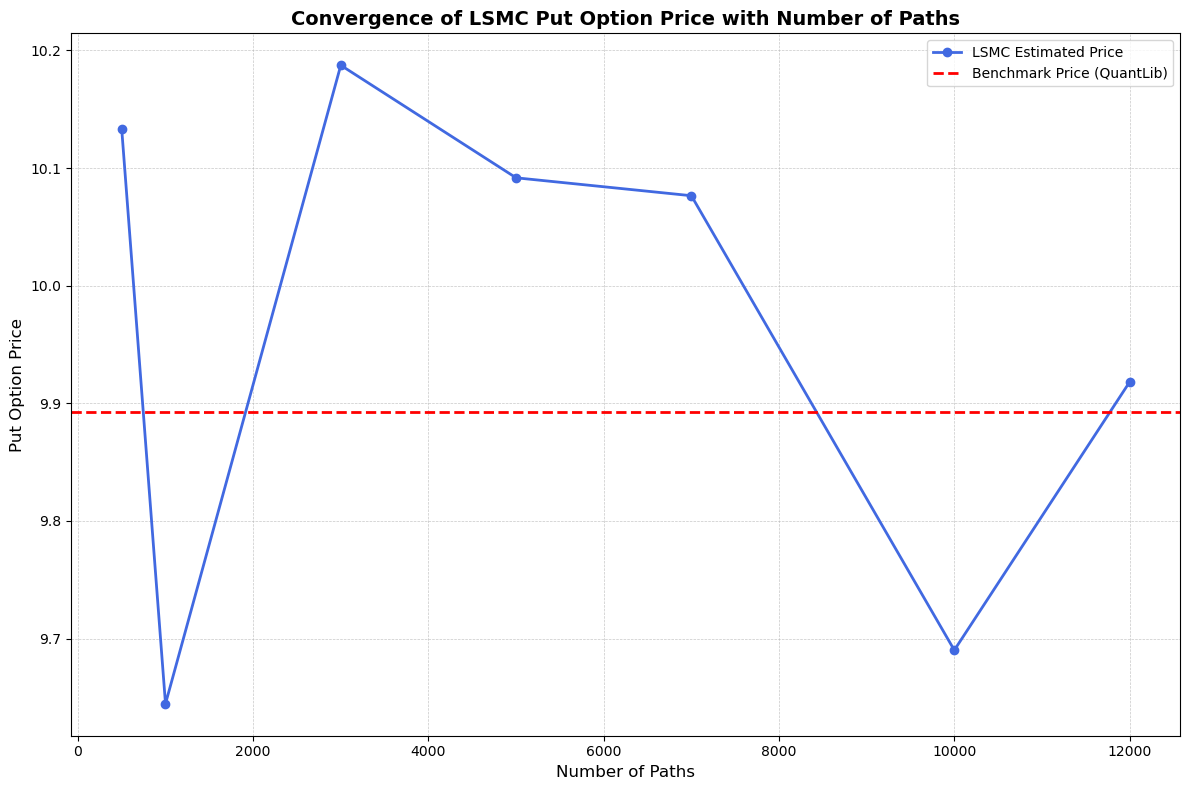

In [14]:
def plot_convergence_with_paths(S0, K, r, T, sigma, n_time_steps, option_type, exercise_type, barrier_level, path_range,
                                basis_type='Chebyshev', degree=4):
    lsmc_prices = []
    n_paths_list = path_range
    benchmark_option = get_quantlib_option(
        S0, K, r, T, sigma, n_time_steps, option_type, exercise_type, barrier_level
    )
    benchmark_price = benchmark_option.NPV()

    dt = T / n_time_steps
    for n_paths in n_paths_list:
        paths = generate_asset_paths(S0, r, sigma, T, n_time_steps, n_paths)
        lsmc_price, _ = lsmc_option_pricing(paths, K, r, dt, option_type, barrier_level, exercise_type,
                                            basis_type, degree)
        lsmc_prices.append(lsmc_price)

    plt.figure(figsize=(12, 8))
    plt.plot(n_paths_list, lsmc_prices, color='royalblue', marker='o', linestyle='-', linewidth=2, markersize=6,
             label='LSMC Estimated Price')

    # Benchmark line
    plt.axhline(benchmark_price, color='red', linestyle='--', linewidth=2, label='Benchmark Price (QuantLib)')

    # Plot styling
    plt.xlabel('Number of Paths', fontsize=12)
    plt.ylabel(f'{option_type} Option Price', fontsize=12)
    plt.title(f'Convergence of LSMC {option_type} Option Price with Number of Paths', fontsize=14, fontweight='bold')
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


np.random.seed(42)
path_range = [500, 1000, 3000, 5000, 7000, 10000, 12000]
plot_convergence_with_paths(S0=S0, K=K, r=r, T=T, sigma=sigma, n_time_steps=n_time_steps,
                            option_type=option_type, exercise_type=exercise_type, barrier_level=barrier_level,
                            path_range=path_range, basis_type=basis_type, degree=degree)


### 3 - AMC convergence w.r.t. number of time steps

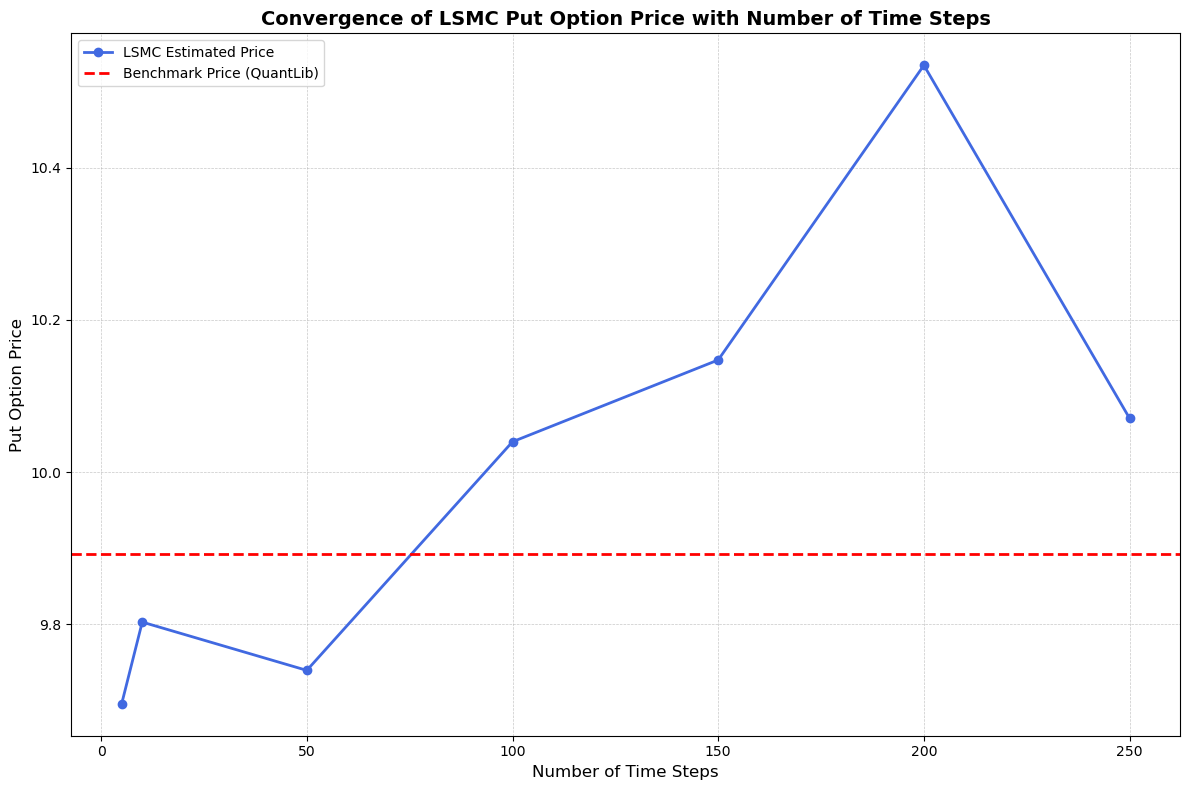

In [15]:
def plot_convergence_with_time_steps(S0, K, r, T, sigma, n_paths, option_type, exercise_type, barrier_level,
                                     time_step_range, basis_type='Chebyshev', degree=4):
    lsmc_prices = []

    # Calculate the benchmark option price using QuantLib using high resolution time grid
    high_res_steps = max(time_step_range) * 10  # 10x resolution
    benchmark_option = get_quantlib_option(S0, K, r, T, sigma, high_res_steps, option_type,
                                           exercise_type, barrier_level)
    benchmark_price = benchmark_option.NPV()

    for n_time_steps in time_step_range:
        dt = T / n_time_steps
        paths = generate_asset_paths(S0, r, sigma, T, n_time_steps, n_paths)
        lsmc_price, _ = lsmc_option_pricing(paths, K, r, dt, option_type, barrier_level, exercise_type,
                                            basis_type, degree)
        lsmc_prices.append(lsmc_price)

    plt.figure(figsize=(12, 8))
    plt.plot(time_step_range, lsmc_prices, color='royalblue', marker='o', linestyle='-', linewidth=2, markersize=6,
             label='LSMC Estimated Price')

    # Benchmark line
    plt.axhline(benchmark_price, color='red', linestyle='--', linewidth=2, label='Benchmark Price (QuantLib)')

    # Plot styling
    plt.xlabel('Number of Time Steps', fontsize=12)
    plt.ylabel(f'{option_type} Option Price', fontsize=12)
    plt.title(f'Convergence of LSMC {option_type} Option Price with Number of Time Steps', fontsize=14, fontweight='bold')
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


np.random.seed(42)
time_step_range = [5, 10, 50, 100, 150, 200, 250]
plot_convergence_with_time_steps(S0=S0, K=K, r=r, T=T, sigma=sigma, n_paths=n_paths,
                                 option_type=option_type, exercise_type=exercise_type, barrier_level=barrier_level,
                                 time_step_range=time_step_range, basis_type=basis_type, degree=degree)


### 4 - AMC convergence w.r.t. number of MC paths & time grid simulatenously

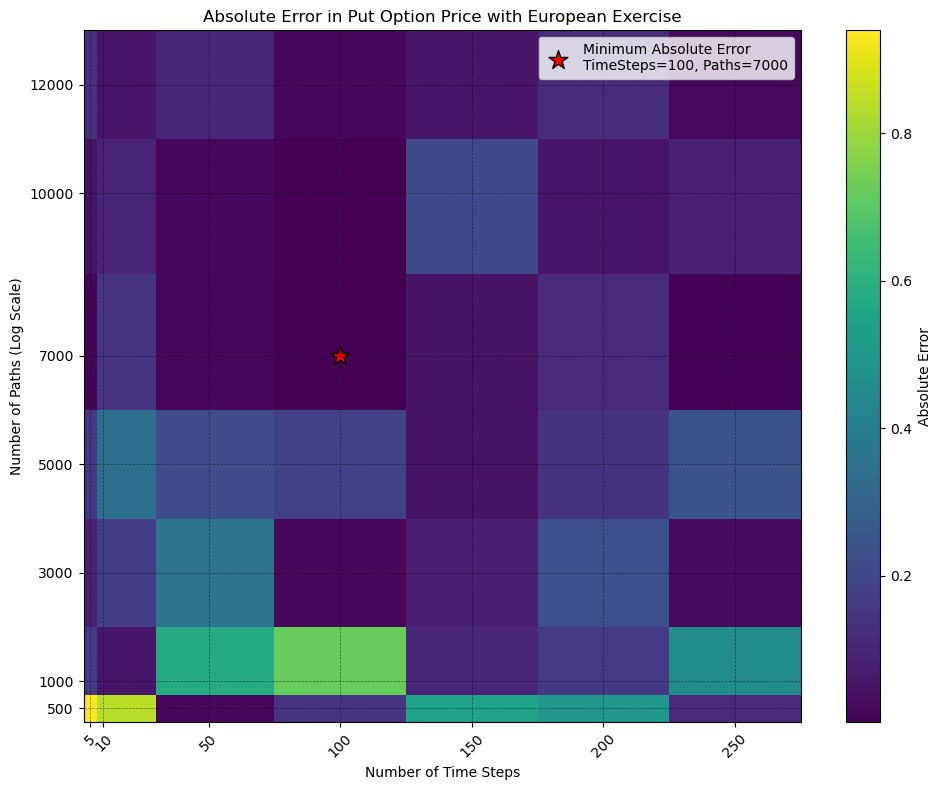

In [16]:
def plot_error_heatmap(S0, K, r, T, sigma, time_step_range, path_range, option_type, exercise_type, barrier_level,
                       basis_type='Chebyshev', degree=4):
    # Initialize a matrix to hold the absolute error for each (time step, path) pair
    error_matrix = np.zeros((len(path_range), len(time_step_range)))

    # Calculate the benchmark option price using QuantLib using high resolution time grid
    high_res_steps = max(time_step_range) * 10  # Increase resolution for accuracy
    benchmark_option = get_quantlib_option(S0, K, r, T, sigma, high_res_steps, option_type, exercise_type, barrier_level)
    benchmark_price = benchmark_option.NPV()

    # Fill the error matrix with absolute errors
    for i, n_paths in enumerate(path_range):
        for j, n_time_steps in enumerate(time_step_range):
            dt = T / n_time_steps
            paths = generate_asset_paths(S0, r, sigma, T, n_time_steps, n_paths)
            lsmc_price, _ = lsmc_option_pricing(paths, K, r, dt, option_type, barrier_level, exercise_type,
                                                basis_type=basis_type, degree=degree)
            # Store the absolute error in the matrix
            error_matrix[i, j] = abs(lsmc_price - benchmark_price)

    # Find the indices of the minimum error
    min_error_index = np.unravel_index(np.argmin(error_matrix, axis=None), error_matrix.shape)
    min_error_value = error_matrix[min_error_index]
    min_n_paths = path_range[min_error_index[0]]
    min_n_time_steps = time_step_range[min_error_index[1]]

    # Plot the heatmap of absolute errors
    plt.figure(figsize=(10, 8))
    c = plt.pcolormesh(time_step_range, path_range, error_matrix, shading='auto', cmap='viridis')
    plt.colorbar(c, label='Absolute Error')

    # Highlight the minimum combination of time steps and paths
    plt.scatter(min_n_time_steps, min_n_paths, color='red', s=200, edgecolor='black', marker='*',
                label=f'Minimum Absolute Error\nTimeSteps={min_n_time_steps}, Paths={min_n_paths}')

    # Set ticks to match the tested points and add grid lines
    plt.xticks(time_step_range, rotation=45)
    plt.yticks(path_range)
    plt.grid(visible=True, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    # Labels and title
    plt.xlabel("Number of Time Steps")
    plt.ylabel("Number of Paths (Log Scale)")
    plt.title(f"Absolute Error in {option_type} Option Price with {exercise_type} Exercise")
    plt.legend()
    plt.tight_layout()
    plt.show()


np.random.seed(42)
plot_error_heatmap(S0=S0, K=K, r=r, T=T, sigma=sigma, time_step_range=time_step_range, path_range=path_range,
                   option_type=option_type, exercise_type=exercise_type, barrier_level=barrier_level,
                   basis_type=basis_type, degree=degree)

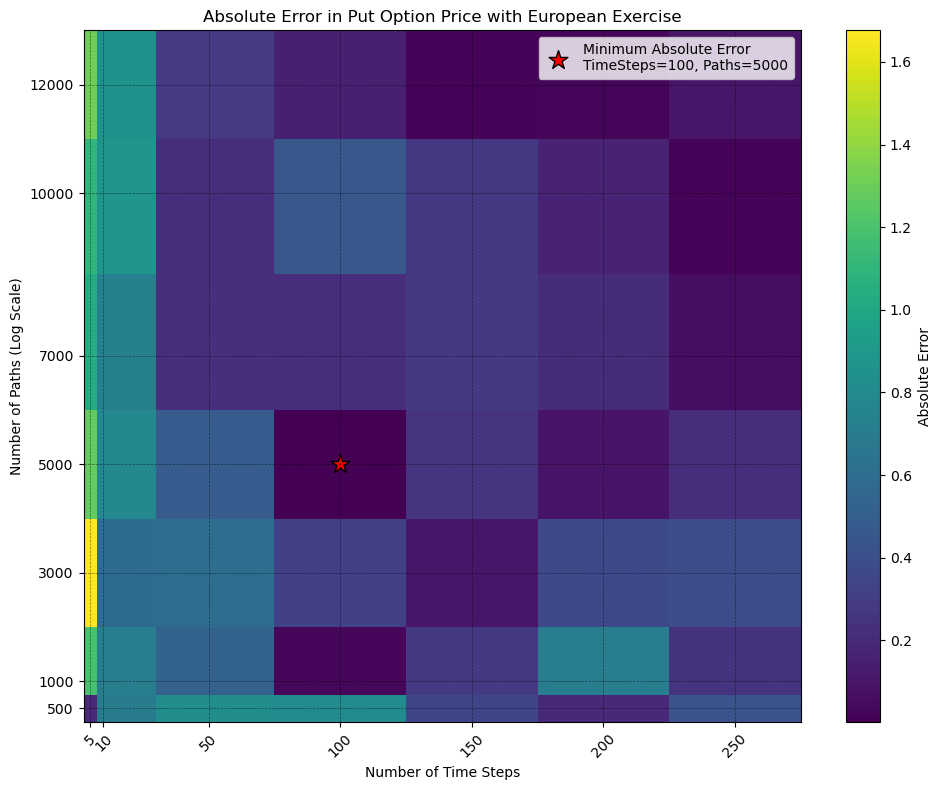

In [17]:
plot_error_heatmap(S0=S0, K=K, r=r, T=T, sigma=sigma, time_step_range=time_step_range, path_range=path_range,
                   option_type=option_type, exercise_type=exercise_type, barrier_level=80,
                   basis_type=basis_type, degree=degree)